# Window Operations with Rasterio and GeoWombat

----------------

```{admonition} Learning Objectives
* Conduct and understand window operations with rasterio
* Conduct window operations with GeoWombat
```
```{admonition} Review
* [Geospatial Raster Data](c_rasters.md)
```

----------------

## Background

Moving windows or filters are often used in raster analysis. For example, they can be used to obtain the maximum value within a certain neighborhood, to smooth out values, or detect holes or edges (i.e., where pixel values that are near each other change abruptly).

These moving windows can also be called filters or kernels. They can be of many different sizes and shapes (the most common is 3-cell-by-3-cell rectangular window) and can have different or the same values for each cell. The center of the filter can be called the target cell or the center pixel, and the surrounding cells are referred to as the neighbors.

The filter passes through all *non-edge* cells in the raster. During each pass of the filter, the center cell is updated based on the cells adjacent to it. In the `3x3` filter example, the center cell is updated by the eight cells that neighbor it. The filter then pulls the values from the neighboring cells and the center pixel itself, performs a calculation based on the filter values (e.g., calculates the mean), reports that resulting value back to the identical location of the original pixel, moves to the next pixel, and repeats the process.

```{figure} ../_static/img/raster_sliding_window.jpg
:name: Sliding Window Operations
Sliding window operations move across an entire raster.
```

The filter values can essentially be any number--they can be the same across the filter or be all different. The values determine how the output is calculated (equation below assuming a `3x3` filter for nine cells total in the kernel):

$$
    X_{w} = \sum_{i=1}^{9}X_{i}k_{i}
$$

*where:*
  X_{i} = raster cell value

  k_{i} = kernel cell value

  i = index of cells in the nine kernel cell values


The values also determine *what* is calculated. For example, setting all filter values to `1` will result in the filter outputting the sum of all raster pixel values within the filter. Setting all filter values to `1/9` for a `3x3` filter will result in the filter outputting the average of all raster pixel values within the filter.

```{figure} ../_static/img/raster_window_operations.jpg
:name: Moving Window Operation Examples
Example filter values for `3x3` moving windows. Different filter value combinations and arrangements can produce different outputs.
```

For more information on moving windows, see the ["Neighborhood Operations" section in this chapter on raster geoprocessing](https://saylordotorg.github.io/text_essentials-of-geographic-information-systems/s12-02-scale-of-analysis.html).

```{attention}
With window operations, the edge pixels will generally be cut out from the output because those edge pixels do not have neighboring pixels all around it. As window operations generally require a pixel to be surrounded on all four sides, we cannot perform calculations on these edge pixels. The pixels that constitute the "edge" depends on the shape of the kernel. For example, a `3x3` kernel only requires 1 neighboring pixel in each direction, so only the outer ring of pixels will be cut out from the output. A `5x5` kernel requires 2 neighboring pixels in each direction, so the two outer rings of pixels will be cut out.
```

## Setup

We'll explore two methods, one using `rasterio` and another using `GeoWombat`.

First, we'll import our modules (click the + below to show code cell).

In [1]:
# Import modules
import geowombat as gw
import numpy as np
from itertools import product
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt

## Window operations with rasterio

The most intuitive way to perform window operations in Python is to use a `for` loop. With this method, we would iterate through each non-edge pixel, obtain the surrounding pixel values and the center pixel value, perform some sort of calculation, report that resulting value back to the identical location of the original pixel, move to the next pixel, and repeat the process. Iterating through each pixel, however, has the potential to be extremely time and computationally intensive (there could be many, many pixels).

To mitigate this limitation, instead of using a `for` loop, we can get each neighbor value simultaneously for all non-edge pixels. Another way to think of it is that instead of using a `for` loop to iterate through each pixel to get neighboring values, we can iterate through each kernel position to get the neighboring value corresponding to a certain kernel position for all non-edge pixels at once. This is what a vectorized sliding window does.

The vectorized sliding window is grounded in the concept that each position in the kernel has a certain relative position or offset (e.g., one pixel to the left) from the center pixel of the kernel. This method works because each pixel in a raster is in essence a neighbor to at least one other pixel. The vectorized sliding window simply offsets itself within the raster array extent so that each pixel that falls within the vectorized sliding window is the neighbor of the same relative position (e.g., one pixel to the left) to its center pixel.

A vectorized sliding window is created for each position in the kernel. The vectorized sliding window of a certain kernel position is applied over the raster and obtains--all at once--the neighboring pixel value corresponding to that kernel position for all non-edge pixels. The size of vectorized sliding window is dependent on the size of the raster and kernel but will always fall between the two.

For more conceptual information on vectorized sliding windows and how they compare to iterating through each pixel, see [this article](https://opensourceoptions.com/blog/vectorize-moving-window-grid-operations-on-numpy-arrays/).

Let's create a raster (click the + below to show code cell).

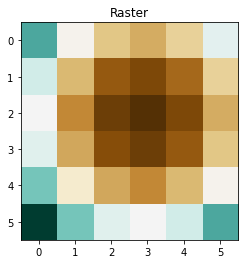

[[13776.    8586.24  5573.76  4738.56  6080.64  9600.  ]
 [10256.64  5066.88  2054.4   1219.2   2561.28  6080.64]
 [ 8914.56  3724.8    712.32  -122.88  1219.2   4738.56]
 [ 9749.76  4560.    1547.52   712.32  2054.4   5573.76]
 [12762.24  7572.48  4560.    3724.8   5066.88  8586.24]
 [17952.   12762.24  9749.76  8914.56 10256.64 13776.  ]]


In [2]:
# Generate mesh grid for rasters
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

# Generate values for mesh grid
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z3 = np.abs(((X + 3) + (Y - 8) ** 2) / 3 ** 2)

# Generate raster values
Z = (Z1 - Z2)

# Set transform
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

# Save first raster
with rasterio.open(
        "../temp/window_raster.tif",
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs="+proj=latlong",
        transform=transform,
) as new_dataset:
        new_dataset.write(Z, 1)

# Open and read raster
src = rasterio.open("../temp/window_raster.tif")
raster = src.read(1)

# Plot raster
plt.imshow(raster, cmap="BrBG")
plt.title("Raster")
plt.show()

# Show raster values
print(raster)

### Create kernel

Second, we can generate a kernel array. The array can consist of a single value or multiple values. Below, we generate a `3x3` kernel consisting of the value `1/9`. This kernel will output the average value of the center cell and its surrounding eight neighbors.

```{important} The kernel should have an odd number of rows and columns and should not have more rows and columns than the input raster.
```

```{tip}
To create a non-rectangular shape, simply add `0`s in the kernel positions to be ignored.
```

In [3]:
# Create a kernel to calculate the average
kernel = np.full((3, 3), 1/9)

# Get kernel shape
kernel_shape = kernel.shape

# Convert the kernel to a flattened array
kernel_array = np.ravel(kernel)

### Create output arrays

Next, we will create two arrays that will store our calculations.

The first array is the output array, which has the same shape as that of the input raster. We will initially fill the array with placeholder values. This array will be the final result that is exported and saved.

In [4]:
# Create raster array with placeholder values in shape of raster
output_rio = np.full((raster.shape[0], raster.shape[1]), -9999)

# Set array data type
output_rio = output_rio.astype(np.float64) ###

# Display raster array with placeholder values
print(output_rio)

[[-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]]


The second array, initially filled with `0`s, will hold the pixel value as calculated from the vectorized sliding windows (e.g., mean). Since we are not performing calculations on any edge pixels, the shape of this array is slightly smaller than that of the input raster and also dependent on the shape of the kernel. This array will be inserted into and replace the non-edge placeholder values in the output array (which we just created).

In [5]:
# Create raster array used to store window operation calculations for each pixel (excluding boundary pixels)
aggregate = np.full((raster.shape[0] - kernel_shape[0] + 1, raster.shape[1] - kernel_shape[1] + 1), 0)

# Set array data type
aggregate = aggregate.astype(np.float64)

# Display raster array
print(aggregate)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Create vectorized sliding window

The next step is to generate the vectorized sliding windows. The shape of the vectorized sliding windows depends on the kernel shape, so we utilize indices and slicing to obtain the extent of a vectorized sliding window for each position in the kernel.

In [6]:
# Generate row index pairs for slicing
pairs_x = list(zip([None] + list(np.arange(1, kernel_shape[0])), list(np.arange(-kernel_shape[0] + 1, 0)) + [None]))

# Generate column index pairs for slicing
pairs_y = list(zip([None] + list(np.arange(1, kernel_shape[1])), list(np.arange(-kernel_shape[1] + 1, 0)) + [None]))

# Combine row and column index pairs together to get the extent for each vectorized sliding window
combos = list(product(pairs_x, pairs_y))

# Display combined pairs
print(combos)

[((None, -2), (None, -2)), ((None, -2), (1, -1)), ((None, -2), (2, None)), ((1, -1), (None, -2)), ((1, -1), (1, -1)), ((1, -1), (2, None)), ((2, None), (None, -2)), ((2, None), (1, -1)), ((2, None), (2, None))]


### Apply vectorized sliding window

Once the vectorized sliding windows are specified, we can apply them to the raster. The vectorized sliding window will get a subset of the raster array, and we can multiply all the pixel values in that subset by the corresponding value in the kernel, which is based on window's specific kernel position.

The product is then added to the array that keeps track of the running total.

In [7]:
# Create empty list to store each window operation calculation
sub_array_list = []

# Iterate through the combined pairs (which give extent of a sliding window)
for p in range(len(combos)):

    # Get the sub-array via slicing and multiply all the values by corresponding value in kernel (based on location)
    sub_array = raster[combos[p][0][0]:combos[p][0][1], combos[p][1][0]:combos[p][1][1]] * kernel_array[p]

    # Add sub-array values to array storing window operation calculations
    aggregate += sub_array

    # Add sub-array to list
    sub_array_list.append(sub_array)

# View array storing window operation calculations
print(aggregate)

[[6518.4  3505.92 2670.72 4012.8 ]
 [5176.32 2163.84 1328.64 2670.72]
 [6011.52 2999.04 2163.84 3505.92]
 [9024.   6011.52 5176.32 6518.4 ]]


Once we get the aggregate of all windows, we can perform additional computations. In this case, we multiply all values by `2`.

In [8]:
# Get average value
aggregate = aggregate * 2

# View array storing window operation calculations
print(aggregate)

[[13036.8   7011.84  5341.44  8025.6 ]
 [10352.64  4327.68  2657.28  5341.44]
 [12023.04  5998.08  4327.68  7011.84]
 [18048.   12023.04 10352.64 13036.8 ]]


### Window operations with predefined functions

We can also perform window operations with predefined functions, such as getting the maximum value of a pixel and its surrounding pixels. We simply take the calculations from each vectorized sliding window and get the maximum value from those calculations.

```{tip}
To get the maximum or minimum value of a pixel and its surrounding neighbors, the kernel should be filled with values of `1` so that the pixel values don't change.
```

In [9]:
# Get maximum value
window_maximum = np.maximum.reduce(sub_array_list)
print(window_maximum)

[[1530.66666667  954.02666667  675.62666667 1066.66666667]
 [1139.62666667  562.98666667  284.58666667  675.62666667]
 [1418.02666667  841.38666667  562.98666667  954.02666667]
 [1994.66666667 1418.02666667 1139.62666667 1530.66666667]]


### Save output

We can insert the processed aggregate array into the output array, with each value replacing the placeholder value at its corresponding original position in the array. Recall that because edge pixels are ignored, the edge pixels of the output array will still keep their placeholder values.

In this example, each non-edge output pixel value is the average pixel value--with pixel values drawn from the input raster--of the 8 pixels surrounding that pixel and the pixel itself.

In [10]:
# Use kernel shape to determine the row and column index extent of the calculated array
n = int((kernel_shape[0] - 1) / 2)
m = int((kernel_shape[1] - 1) / 2)

# Replace placeholder values in the output array with the corresponding values (based on location) from the calculated array
output_rio[n:-n, m:-m] = aggregate

# Display output array
print(output_rio)

[[-9999.   -9999.   -9999.   -9999.   -9999.   -9999.  ]
 [-9999.   13036.8   7011.84  5341.44  8025.6  -9999.  ]
 [-9999.   10352.64  4327.68  2657.28  5341.44 -9999.  ]
 [-9999.   12023.04  5998.08  4327.68  7011.84 -9999.  ]
 [-9999.   18048.   12023.04 10352.64 13036.8  -9999.  ]
 [-9999.   -9999.   -9999.   -9999.   -9999.   -9999.  ]]


Finally, we can export the raster (click the + below to show code cell).

In [11]:
# Export raster
with rasterio.open(
        "../temp/raster_window_3x3_average.tif", "w",
        driver="GTiff",
        transform = src.transform,
        dtype=rasterio.float64,
        count=1,
        width=src.width,
        height=src.height) as dst:
    dst.write(output_rio, indexes=1)

## Window operations with GeoWombat

We can use `GeoWombat` for window operations if we're only interested in calculating a statistic. The code to do this with `GeoWombat` is less complex and much shorter than with `rasterio`--we can simply use the `geowombat.moving()` function.

The `geowombat.moving()` function provides us with a few parameters that we can specify:

| Parameter | Description |
| :------------ | ----------------------------------: |
| `stat` | statistic calculated (options: mean, standard deviation, variance, minimum, maximum, percentile) |
| `perc` | percentile used for window operation if `stat = perc`
| `w` | moving window size in pixels
| `nodata` | value that will be ignored in calculations |

For more information this function, see the [function documentation](https://geowombat.readthedocs.io/en/latest/moving.html).

<xarray.DataArray 'stack-ebf4780c581d90fd1a920017bb13440d' (band: 1, y: 6, x: 6)>
dask.array<stack, shape=(1, 6, 6), dtype=float64, chunksize=(1, 6, 6), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 90.0 60.0 30.0 0.0 -30.0 -60.0
  * x        (x) float64 -90.0 -60.0 -30.0 0.0 30.0 60.0
Attributes: (12/14)
    transform:           (30.0, 0.0, -105.0, 0.0, -30.0, 105.0)
    crs:                 +init=epsg:4326
    res:                 (30.0, 30.0)
    is_tiled:            0
    nodatavals:          (nan,)
    scales:              (1.0,)
    ...                  ...
    filename:            ../temp/window_raster.tif
    resampling:          nearest
    data_are_separate:   0
    data_are_stacked:    0
    moving_stat:         mean
    moving_window_size:  5


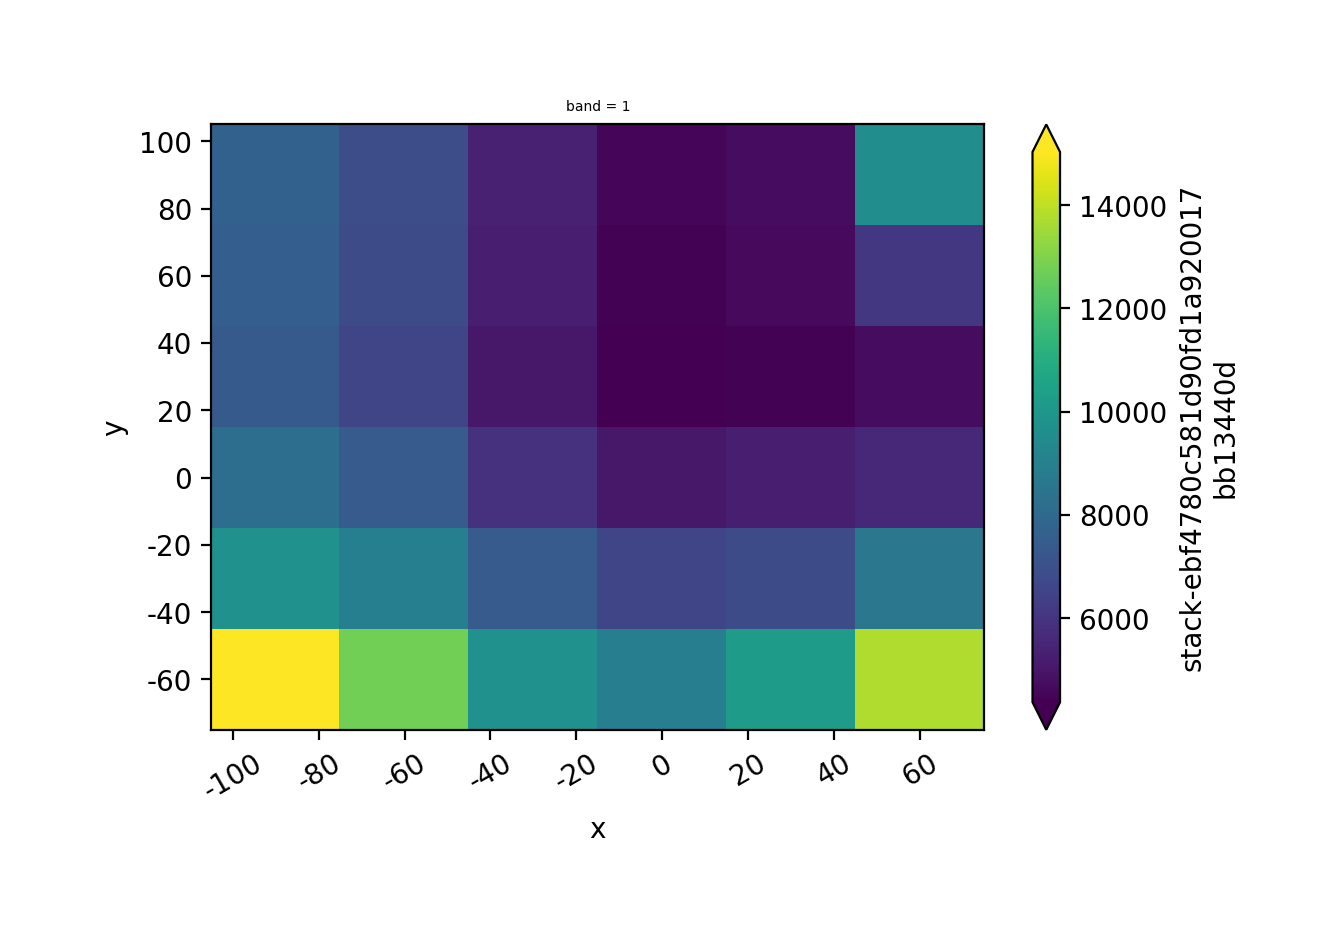

In [12]:
# Open file
with gw.open("../temp/window_raster.tif") as src:

    # Create plot
    fig, ax = plt.subplots(dpi = 200)

    # Calculate local average
    output_gw = src.gw.moving(stat = 'mean', w = 5, n_jobs = 4, nodata = 0)
    print(output_gw)

    # Plot raster
    output_gw.sel(band=1).gw.imshow(robust = True, ax = ax)
    plt.tight_layout(pad = 1)